In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import date
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

In [2]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20, 10

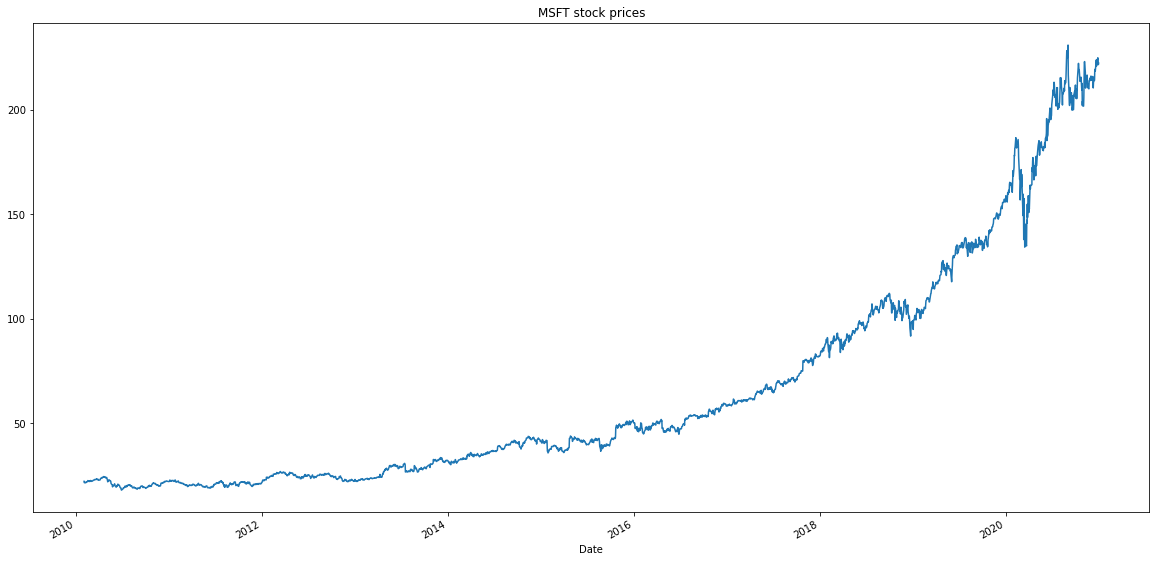

In [3]:
def getData(tickerSymbol, period, start, end = date.today()):
    tickerData = yf.Ticker(tickerSymbol)
    tickerDf = tickerData.history(period = period,  start = start, end = end)
    return tickerDf

tickerSymbol = 'MSFT' #select stock ticker symbol by visiting yahoo finance
df = getData(tickerSymbol, period = '6mo', start = '2010-02-04')
df['Close'].plot(title=tickerSymbol+" stock prices")
plt.show()

In [4]:
data = df['Close']
data.head()

Date
2010-02-03    22.298431
2010-02-04    21.683146
2010-02-05    21.823339
2010-02-08    21.589678
2010-02-09    21.815544
Name: Close, dtype: float64

In [5]:
dataset = data.values
dataset = dataset.reshape(dataset.shape[0], 1)

In [6]:
print(dataset.shape)

(2748, 1)


In [7]:
num = int(0.9*dataset.shape[0]) #using first 90% values for training
train = dataset[:num, :]
valid = dataset[num:, :]

In [8]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

In [9]:
x_train, y_train = [], []

In [10]:
for i in range(60, len(train)):
    x_train.append(scaled_data[i-60:i, 0])
    y_train.append(scaled_data[i, 0])

In [11]:
type(train)

numpy.ndarray

In [12]:
x_train = np.array(x_train)
y_train = np.array(y_train)

In [13]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [14]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

In [15]:
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=1, batch_size=32)

Train on 2413 samples
2413/2413 [==============================] - 5s 2ms/sample - loss: 0.0029


In [16]:
inputs = data[len(data) - len(valid) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

In [17]:
X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)

In [18]:
rms=np.sqrt(np.mean(np.power((valid-closing_price),2)))
print(rms)

8.288208145338487


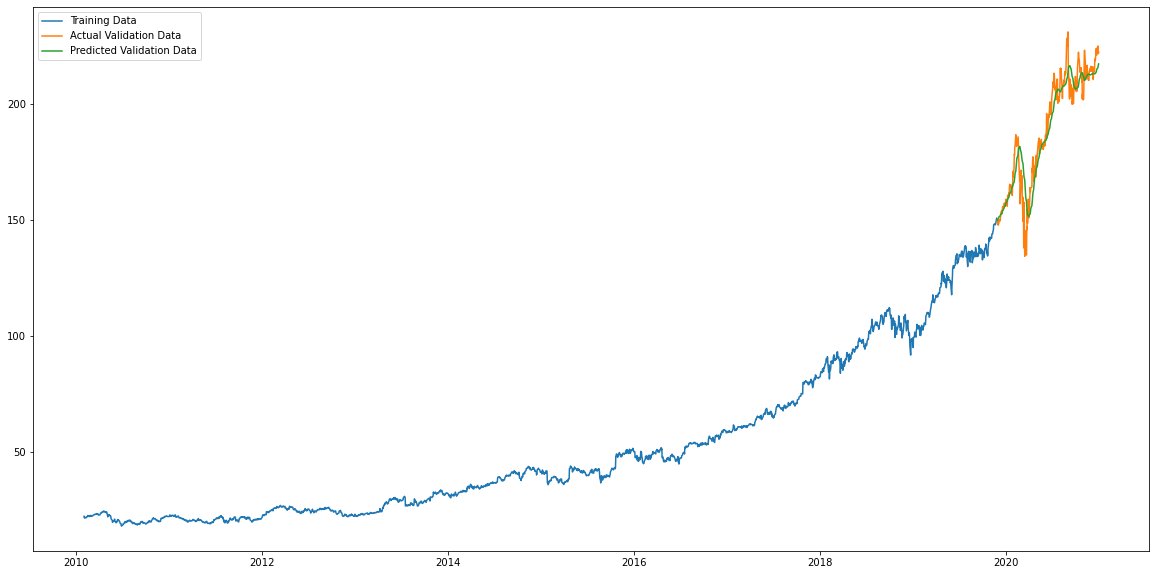

In [19]:
train = data[:num]
valid = data[num:]
pred = pd.DataFrame(closing_price, columns = ['Close'], index = valid.index)
plt.plot(train, label = 'Training Data')
plt.plot(valid, label = 'Actual Validation Data')
plt.plot(pred, label = 'Predicted Validation Data')
plt.legend()